# Sentence Transformers: Tests

[SBERT](https://www.sbert.net/) is a powerful library which is able to convert any text into text embedding vectors which capture semantic meaning. Then, those vectors can be used for downstream applications, such as:

- Clustering
- Look for similar documents
- Classification
- etc.

Here is the original [SBERT Paper](https://arxiv.org/abs/1908.10084).

And here are some quick features of SBERT, highlighted by me:

- It is lightweight.
- It can be used within the [HuggingFace framework](https://huggingface.co/sentence-transformers) or without it, simply by installing it with `pip install -U sentence-transformers`.
- The embedding vector size is 384.
- There are many models available, among which we can find multi-lingual models (i.e., English & German & Spanish, etc.)
- We can pass to it regular natural text or even short one-two word clauses.
- The official documentation seems very good: [https://www.sbert.net/index.html](https://www.sbert.net/index.html).

The notebook [`sbert_tests.ipynb`](./sbert_tests.ipynb) performs several tests and implements downstream applications:

- Tests with the SBERT or `sentence_transformers` library
- Tests with the HuggingFace library
- Evaluation with the [AG News Classification Dataset](https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset)
  - Comparison of the simmilarity matrices of text embeddings and `CountVectorizer` one-hot vectors
  - Basic K-Means clustering and T-SNE visualization
  - PCA compression analysis
  - Classification with Random Forest Models

Note that no thorough NLP processing is performed in the notebook, instead, the focus lies on the evaluation of SBERT.

For more related information, you can check these repositories of mine:

- [deep_learning_udacity](https://github.com/mxagar/deep_learning_udacity)
- [nlp_guide](https://github.com/mxagar/nlp_guide)

In [1]:
import os
import re
import math
import pandas as pd
import numpy as np
from numpy.linalg import norm
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import pairwise
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.metrics import roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import calinski_harabasz_score

from sentence_transformers import SentenceTransformer

## 1. Tests Using Off-the-Shelf Library

In [2]:
from sentence_transformers import SentenceTransformer
sentences = ["This is an example sentence", "Each sentence is converted"]

model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
embeddings = model.encode(sentences)
print(len(embeddings[0]))
#print(embeddings)

384


In [3]:
base_folder = "./data/ag_news"
df = pd.read_csv(os.path.join(base_folder, "train.csv"))
# Class Index, Title, Description -> label, title, text
df = df.rename(columns={'Class Index': 'label',
                        'Title': 'title',
                        'Description': 'text'})

In [4]:
df["title"].to_list()[:10]

['Wall St. Bears Claw Back Into the Black (Reuters)',
 'Carlyle Looks Toward Commercial Aerospace (Reuters)',
 "Oil and Economy Cloud Stocks' Outlook (Reuters)",
 'Iraq Halts Oil Exports from Main Southern Pipeline (Reuters)',
 'Oil prices soar to all-time record, posing new menace to US economy (AFP)',
 'Stocks End Up, But Near Year Lows (Reuters)',
 'Money Funds Fell in Latest Week (AP)',
 'Fed minutes show dissent over inflation (USATODAY.com)',
 'Safety Net (Forbes.com)',
 'Wall St. Bears Claw Back Into the Black']

In [5]:
embeddings = model.encode(df["title"].to_list()[:10])

In [6]:
embeddings

array([[ 0.07683221,  0.19610068, -0.02445361, ..., -0.55743873,
         0.3361046 ,  0.20765409],
       [ 0.07524935, -0.03401208, -0.15838692, ..., -0.2786484 ,
         0.06885243,  0.07347341],
       [-0.16310546, -0.3713898 , -0.10341208, ..., -0.43687576,
         0.09648123,  0.02917743],
       ...,
       [-0.23995066,  0.15454265, -0.09713075, ...,  0.20344263,
         0.02327895,  0.2583023 ],
       [ 0.04750721, -0.2180928 , -0.5180057 , ..., -0.11462291,
         0.19695146,  0.08486997],
       [ 0.16977923,  0.21054807,  0.0661767 , ..., -0.50831944,
         0.26866195,  0.23463942]], dtype=float32)

In [7]:
embeddings = model.encode(["001", "Hello", "Guten Morgen", "Gruss Gott", "Servus"])

In [8]:
def cosine_similarity(v1, v2):
    cs = np.dot(v1, v2) / (norm(v1)*norm(v2))
    return cs

In [9]:
cosine_similarity(embeddings[1], embeddings[2])

0.78442556

In [10]:
cosine_similarity(embeddings[0], embeddings[2])

0.3689012

In [11]:
cosine_similarity(embeddings[2], embeddings[3])

0.44979104

In [12]:
cosine_similarity(embeddings[1], embeddings[3])

0.44228235

In [13]:
cosine_similarity(embeddings[0], embeddings[4])

0.2511703

## 2. Tests Using HuggingFace Transformers Library

In [14]:
from transformers import AutoTokenizer, AutoModel
import torch

In [15]:
# Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [16]:
# Load model from HuggingFace Hub
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
model = AutoModel.from_pretrained('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')

In [17]:
# Sentences we want sentence embeddings for
sentences = ["[numbering]", "numbering", "number", "[number]", "[code]"]
print(sentences)

['[numbering]', 'numbering', 'number', '[number]', '[code]']


In [18]:
# Tokenize sentences
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
print(encoded_input)

{'input_ids': tensor([[    0,   378,  2606,  1297,   214,   268,     2],
        [    0, 14012,   214,     2,     1,     1,     1],
        [    0, 14012,     2,     1,     1,     1,     1],
        [    0,   378,  2606,  1297,   268,     2,     1],
        [    0,   378, 40899,   268,     2,     1,     1]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0],
        [1, 1, 1, 1, 1, 0, 0]])}


In [19]:
# The decoding seems to work properly!
# That means the words are not altered when the ids are generated
decoded_string = tokenizer.decode(encoded_input["input_ids"][0])
print(decoded_string)

<s> [numbering]</s>


In [20]:
# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

In [21]:
# Perform pooling. In this case, max pooling.
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

In [22]:
print("Sentence embeddings:")
print(sentence_embeddings)

Sentence embeddings:
tensor([[ 0.0321,  0.4080, -0.3090,  ..., -0.0831, -0.0373,  0.2460],
        [ 0.2486,  0.4342, -0.2910,  ..., -0.0832, -0.4673,  0.1604],
        [ 0.1481,  0.3464, -0.2561,  ...,  0.0312, -0.3685,  0.0793],
        [-0.0172,  0.3247, -0.2383,  ..., -0.0808, -0.0265,  0.1525],
        [-0.0778,  0.1655, -0.4765,  ..., -0.0661,  0.1645, -0.0667]])


In [23]:
cosine_similarity(sentence_embeddings[4], sentence_embeddings[2])

0.3950505

## 3. Evaluation with AG News Text Data

In [24]:
base_folder = "./data/ag_news"
df = pd.read_csv(os.path.join(base_folder, "train.csv"))
# Class Index, Title, Description -> label, title, text
df = df.rename(columns={'Class Index': 'label',
                        'Title': 'title',
                        'Description': 'text'})

In [25]:
df.head()

,label,title,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [26]:
df.shape

(120000, 3)

In [27]:
# Take only the first 10k entries for test purposes
df = df.iloc[:10_000, :]

In [28]:
def load_word_list(file_path):
    word_list = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            word = line.strip()
            if word:  # Skip empty lines
                word_list.append(word)
    return word_list

stop_words = load_word_list("english_stop_words.txt")

In [29]:
def process_text(text, remove_words=None, replace_dict=None, special_identifiers=("[","]")):
    """This function cleans the text by perfoming these tasks:
    
    - Replace the words in the passed dictionary: replace values with keys.
    - Remove the words in the passed list; e.g., stop words
    - Replace specific patterns with special tokens:
        - dates: 02.01.02, 02.01.2002
        - numberings: 01, 001
        - numbers: 1, 1.23
        - codes: 7y889w
        - single letters: A
    """
    if remove_words is None:
        remove_words = []
    if replace_dict is None:
        replace_dict = {}
        
    start = special_identifiers[0] # [
    end = special_identifiers[1] # ]
        
    # Convert to lowercase
    text = text.lower()

    # Remove specific words from the text
    remove_words_regex = r'\b(?:{})\b'.format('|'.join(map(re.escape, remove_words)))
    text = re.sub(remove_words_regex, '', text)

    # Replace words based on the provided dictionary
    for key, values in replace_dict.items():
        for value in values:
            text = re.sub(r'\b{}\b'.format(re.escape(value)), key, text)

    # Replace date-like patterns with "[date]"
    text = re.sub(r'\b\d{2}\.\d{2}\.(?:\d{2}|\d{4})\b', start+'date'+end, text)

    # Replace numbers starting with 0 followed by digits with "[numbering]"
    text = re.sub(r'\b0\d+\b', start+'numbering'+end, text)

    # Replace numbers with "[number]"
    text = re.sub(r'\b(?:[-+]?\d+(?:,\d+)?(?:\.\d+)?)\b', start+'number'+end, text)

    # Replace words with letters and digits with "[code]"
    text = re.sub(r'(?:(?<=\s)|^)(?=.*[a-zA-Z])(?=.*\d)[a-zA-Z\d]{5,}(?=\s|$)', start+'code'+end, text)
    
    # Replace single-letter words with "[letter]"
    text = re.sub(r'(?:(?<=\s)|^)[a-zA-Z](?=\s|$)', start+'letter'+end, text)
                
    return text

synonyms_dict = {
    "vehicle": ["car", "auto"],
    # extend it!
}

df['title_proc'] = df['title'].fillna("").apply(lambda x: process_text(x, remove_words=stop_words, replace_dict=synonyms_dict))

In [30]:
df['title_proc'].head(10)

0           wall st. bears claw back   black (reuters)
1    carlyle looks toward commercial aerospace (reu...
2         oil  economy cloud stocks' outlook (reuters)
3    iraq halts oil exports  main southern pipeline...
4    oil prices soar  -time record, posing new mena...
5               stocks end ,  near year lows (reuters)
6                   money funds fell  latest week (ap)
7    fed minutes show dissent  inflation (usatoday....
8                              safety net (forbes.com)
9                     wall st. bears claw back   black
Name: title_proc, dtype: object

In [31]:
def get_vocabulary(df, col_name, pattern=r'\b\w+\b', vocabulary=None, special_identifiers=("[","]")):
    if vocabulary is None:
        vocabulary = set()

    # If special_identifiers are provided, construct the regex pattern to include them
    if special_identifiers:
        start, end = special_identifiers
        pattern_special = r'{}(?:\w+){}'.format(re.escape(start), re.escape(end))
    else:
        pattern_special = None

    # Find all occurrences of the pattern in the column
    matches = df[col_name].fillna('').astype(str).str.lower()

    # Split the text into individual words and add them to the vocabulary set
    for text in matches:
        words = re.findall(pattern, text)
        vocabulary.update(words)
        if pattern_special:
            words_special = re.findall(pattern_special, text)
            vocabulary.update(words_special)

    return vocabulary

vocabulary = get_vocabulary(df, col_name="title_proc")

In [32]:
len(vocabulary)

9957

In [33]:
# Vectorize with binary count values: for each document (page, row),
# detect the tokens in its bemerkung_kurz_proc column
custom_vocabulary = list(vocabulary)
vectorizer = CountVectorizer(vocabulary=custom_vocabulary, binary=True)
text_vectors = vectorizer.fit_transform(df["title_proc"])

In [34]:
# Sparse matrix
#print(text_vectors)
text_vectors.shape

(10000, 9957)

In [35]:
cosine_sim_matrix_count = pairwise.cosine_similarity(text_vectors)

In [36]:
cosine_sim_matrix_count.shape

(10000, 10000)

In [37]:
def generate_text_embeddings(model, df, col_name="title_proc", batch_size=128):
    embeddings = []
    texts = df[col_name].tolist()

    for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
        batch_texts = texts[i:i+batch_size]
        batch_embedding = model.encode(batch_texts)
        embeddings.extend(batch_embedding.tolist())

    return embeddings

model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
#model.max_seq_length = 300 # default 128
df["title_proc_emb"] = generate_text_embeddings(model, df, col_name="title_proc")

Generating embeddings: 100%|██████████| 79/79 [00:05<00:00, 13.33it/s]


In [38]:
df["title_proc_emb"]

0       [-0.05564964562654495, 0.08516271412372589, 0....
1       [0.23612675070762634, -0.059621673077344894, -...
2       [-0.14626827836036682, -0.44417062401771545, -...
3       [0.014113697223365307, -0.17897632718086243, -...
4       [-0.36425715684890747, -0.15141409635543823, 0...
                              ...                        
9995    [-0.26295217871665955, 0.11219624429941177, -0...
9996    [-0.5264227986335754, 0.17974057793617249, -0....
9997    [-0.25902068614959717, 0.3193660378456116, 0.0...
9998    [0.5283610224723816, 0.11335208266973495, -0.1...
9999    [0.02634180150926113, -0.6376862525939941, -0....
Name: title_proc_emb, Length: 10000, dtype: object

In [39]:
embeddings = np.array(df["title_proc_emb"].tolist())
cosine_sim_matrix_emb = pairwise.cosine_similarity(embeddings)

### Comparing the Similarity Matrices

In [40]:
# Compare the similarity matrices
print(np.array_equal(cosine_sim_matrix_count, cosine_sim_matrix_emb))

False


In [41]:
sim_diff = cosine_sim_matrix_count - cosine_sim_matrix_emb

In [42]:
sim_diff.shape

(10000, 10000)

In [43]:
np.min(sim_diff)

-0.8684148843574244

In [44]:
np.max(sim_diff)

0.509829647867661

In [45]:
np.mean(sim_diff)

-0.04136738917974322

In [46]:
np.std(sim_diff)

0.10402917518976787

In [47]:
# Split the matrices into smaller chunks to avoid memory error
chunk_size = 1000
n_chunks = cosine_sim_matrix_count.shape[0] // chunk_size

In [48]:
mean_cosine_sim = 0.0

for i in range(n_chunks):
    start_idx = i * chunk_size
    end_idx = (i + 1) * chunk_size

    # Normalize the chunk of matrices to have values between 0 and 1
    normalized_cosine_sim_matrix_count = (cosine_sim_matrix_count[start_idx:end_idx] + 1) / 2
    normalized_cosine_sim_matrix_emb = (cosine_sim_matrix_emb[start_idx:end_idx] + 1) / 2

    # Compute the cosine similarity between the two normalized matrices
    cosine_sim = pairwise.cosine_similarity(normalized_cosine_sim_matrix_count, normalized_cosine_sim_matrix_emb)

    # Update the mean cosine similarity with the current chunk
    mean_cosine_sim += np.mean(cosine_sim)

# Compute the final mean cosine similarity over all chunks
mean_cosine_sim /= n_chunks

# Both similarity matrices are very similar! :)
print("Mean Cosine Similarity:", mean_cosine_sim)

Mean Cosine Similarity: 0.994211261128708


### Basic K-Means Clustering

In [49]:
X = np.vstack(df["title_proc_emb"].values)

In [50]:
X.shape

(10000, 384)

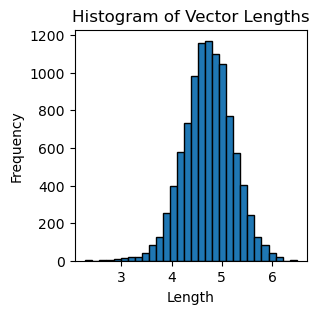

In [51]:
# Compute the length of each row in X
lengths = np.linalg.norm(X, axis=1)

# Create a histogram of the lengths
plt.figure(figsize=(3,3))
plt.hist(lengths, bins=30, edgecolor='black')
plt.title('Histogram of Vector Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [52]:
def evaluate_kmeans_clusters(X, max_clusters=50):
    # We apply K-Means without a known number of clusters,
    # i.e., we create and fit a range of models
    def bic_score(X, labels):
        """
        BIC score for the goodness of fit of clusters.
        This Python function is directly translated from the GoLang code made by the author of the paper. 
        The original code is available here: https://github.com/bobhancock/goxmeans/blob/a78e909e374c6f97ddd04a239658c7c5b7365e5c/km.go#L778
        Also see
        https://towardsdatascience.com/are-you-still-using-the-elbow-method-5d271b3063bd
        """
        
        n_points = len(labels)
        n_clusters = len(set(labels))
        n_dimensions = X.shape[1]
    
        n_parameters = (n_clusters - 1) + (n_dimensions * n_clusters) + 1
    
        loglikelihood = 0
        for label_name in set(labels):
            X_cluster = X[labels == label_name]
            n_points_cluster = len(X_cluster)
            centroid = np.mean(X_cluster, axis=0)
            variance = np.sum((X_cluster - centroid) ** 2) / (len(X_cluster) - 1)
            loglikelihood += \
                n_points_cluster * np.log(n_points_cluster) \
                - n_points_cluster * np.log(n_points) \
                - n_points_cluster * n_dimensions / 2 * np.log(2 * math.pi * variance) \
                - (n_points_cluster - 1) / 2
        
        bic = loglikelihood - (n_parameters / 2) * np.log(n_points)
            
        return bic

    # Run range of K-Means models
    km_list = list()
    for n_clusters in range(2,max_clusters+1):
        km = KMeans(n_clusters=n_clusters,
                    n_init='auto',
                    random_state=42)
        km = km.fit(X)
        labels = km.predict(X)
        # Calculate Calinski-Harabasz score
        ch_score = calinski_harabasz_score(X, labels)
        # BIC score
        bic = bic_score(X, labels)
        # Pack everything
        km_list.append(pd.Series({'clusters': n_clusters, 
                                  'inertia': km.inertia_,
                                  'ch_score': ch_score,
                                  'bic_score': bic,
                                  'model': km}))

    # Create return data
    cluster_data = (pd.concat(km_list, axis=1)
                 .T
                 [['clusters','inertia','ch_score','bic_score']]
                 .set_index('clusters'))

    # Compute the derivative of inertia
    derivative_inertia = np.gradient(cluster_data['inertia'].values)
    second_derivative_inertia = np.gradient(derivative_inertia)
    cluster_data['second_derivative_inertia'] = second_derivative_inertia

    return cluster_data


cluster_data = evaluate_kmeans_clusters(X)

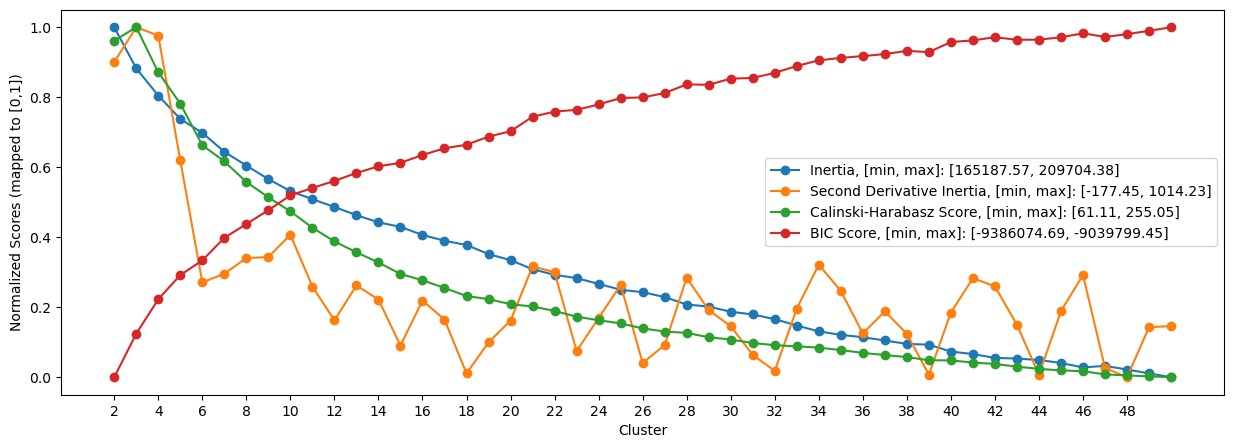

In [53]:
# Unpack values
inertia_values = cluster_data['inertia'].values
second_derivative_inertia = cluster_data['second_derivative_inertia']
ch_values = cluster_data['ch_score'].values
bic_values = cluster_data['bic_score'].values

# Plots
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(cluster_data.index,
        (inertia_values-min(inertia_values))/(max(inertia_values)-min(inertia_values)),
        marker='o', ls='-', label=f"Inertia, [min, max]: [{min(inertia_values):.2f}, {max(inertia_values):.2f}]")
ax.plot(cluster_data.index,
        (second_derivative_inertia-min(second_derivative_inertia))/(max(second_derivative_inertia)-min(second_derivative_inertia)),
        #second_derivative_inertia/max(second_derivative_inertia),
        marker='o', ls='-', label=f"Second Derivative Inertia, [min, max]: [{min(second_derivative_inertia):.2f}, {max(second_derivative_inertia):.2f}]")
ax.plot(cluster_data.index,
        (ch_values-min(ch_values))/(max(ch_values)-min(ch_values)),
        #ch_values/max(abs(ch_values)),
        marker='o', ls='-', label=f"Calinski-Harabasz Score, [min, max]: [{min(ch_values):.2f}, {max(ch_values):.2f}]")
ax.plot(cluster_data.index,
        (bic_values-min(bic_values))/(max(bic_values)-min(bic_values)),
        #bic_values/max(abs(bic_values)),
        marker='o', ls='-', label=f"BIC Score, [min, max]: [{min(bic_values):.2f}, {max(bic_values):.2f}]")
ax.set_xticks(range(min(cluster_data.index), max(cluster_data.index), 2))
#ax.set_xlim(0, max(cluster_data.index))
ax.set(xlabel='Cluster', ylabel='Normalized Scores (mapped to [0,1])')
ax.legend()
plt.show()

In [57]:
# Select a k value
n_clusters = 4
km = KMeans(n_clusters=n_clusters,
            n_init='auto',
            random_state=42)
km = km.fit(X)

# We create a new column with the prediction
clusters = km.predict(X)

In [58]:
# Save?
#df["cluster"] = clusters
df["cluster"] = clusters

In [59]:
df.head()

,label,title,text,title_proc,title_proc_emb,cluster
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall st. bears claw back black (reuters),"[-0.05564964562654495, 0.08516271412372589, 0....",3
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace (reu...,"[0.23612675070762634, -0.059621673077344894, -...",1
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil economy cloud stocks' outlook (reuters),"[-0.14626827836036682, -0.44417062401771545, -...",1
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports main southern pipeline...,"[0.014113697223365307, -0.17897632718086243, -...",0
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","oil prices soar -time record, posing new mena...","[-0.36425715684890747, -0.15141409635543823, 0...",1


In [60]:
tsne = TSNE(n_components=2,
            verbose=1,
            random_state=42)
z = tsne.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.005s...
[t-SNE] Computed neighbors for 10000 samples in 11.152s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 1.563230
[t-SNE] KL divergence after 250 iterations with early exaggeration: 101.930359
[t-SNE] KL divergence after 1000 iterations: 2.372904


[Text(0.5, 1.0, 'Embedding vector T-SNE projection - predicted CLUSTERS')]

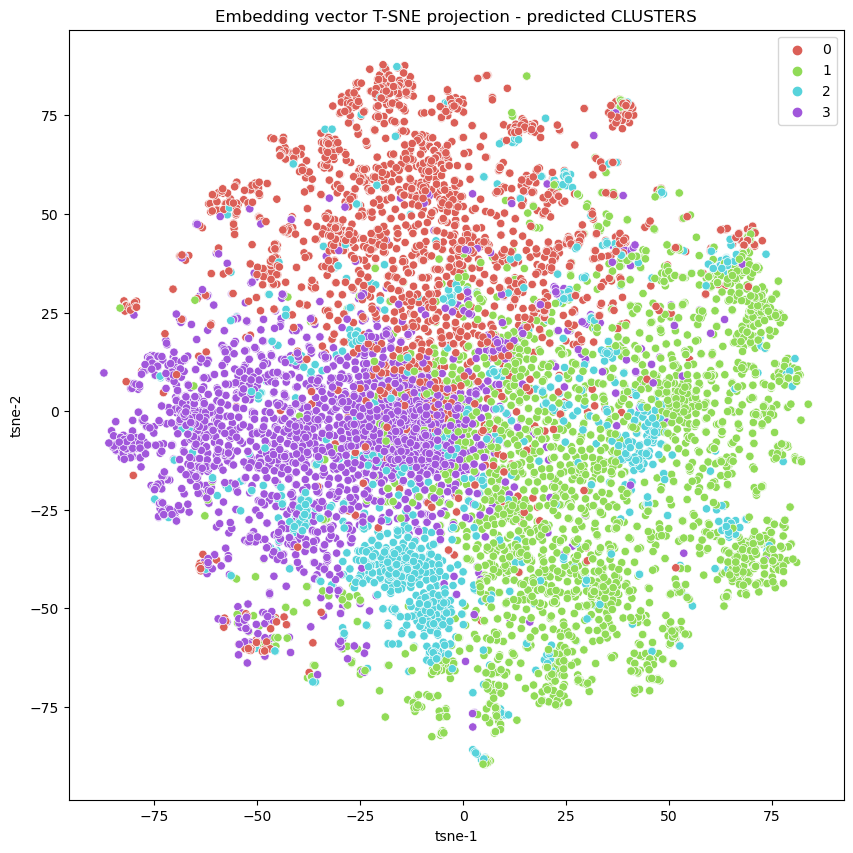

In [61]:
# Plot clusters
df_tsne = pd.DataFrame()
df_tsne["y"] = df["cluster"]
df_tsne["tsne-1"] = z[:,0]
df_tsne["tsne-2"] = z[:,1]
plt.figure(figsize=(10,10))
sns.scatterplot(x="tsne-1", y="tsne-2",
                hue=df_tsne.y.tolist(),
                palette=sns.color_palette("hls", len(df_tsne["y"].unique())),
                data=df_tsne).set(title="Embedding vector T-SNE projection - predicted CLUSTERS")

[Text(0.5, 1.0, 'Embedding vector T-SNE projection - LABELS')]

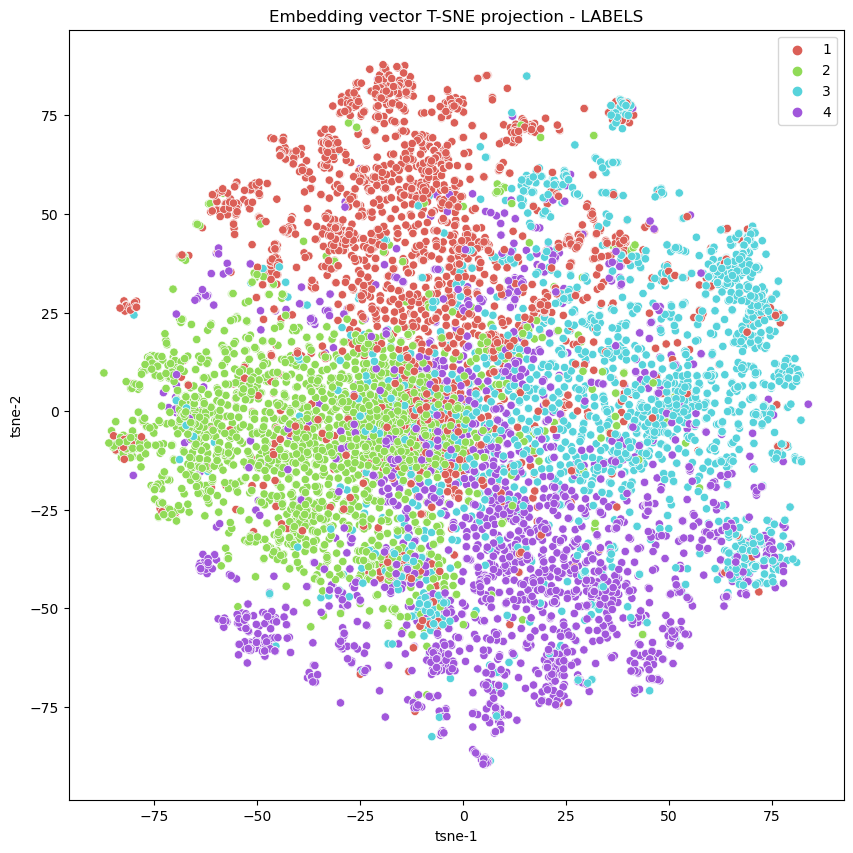

In [62]:
# Plot plan_art labels
df_tsne = pd.DataFrame()
df_tsne["y"] = df["label"]
df_tsne["tsne-1"] = z[:,0]
df_tsne["tsne-2"] = z[:,1]
plt.figure(figsize=(10,10))
sns.scatterplot(x="tsne-1", y="tsne-2",
                hue=df_tsne.y.tolist(),
                palette=sns.color_palette("hls", len(df_tsne["y"].unique())),
                data=df_tsne).set(title="Embedding vector T-SNE projection - LABELS")

### PCA of Embedding Dimensionality

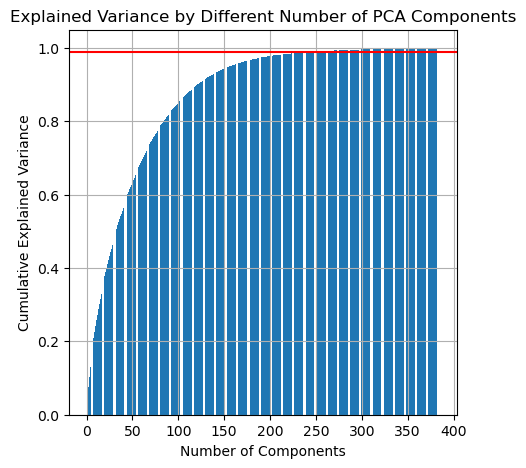

The number of components needed to reach 99.0% variance is: 246


246

In [63]:
def pca_explained_variance_plot(X, threshold=0.95):
    pca = PCA()
    pca.fit(X)

    explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    
    plt.figure(figsize=(5, 5))
    plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
    plt.axhline(y=threshold, color='r', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance by Different Number of PCA Components')
    plt.grid(True)
    plt.show()
    
    num_components = np.where(explained_variance_ratio >= threshold)[0][0] + 1
    print(f"The number of components needed to reach {threshold*100}% variance is: {num_components}")
    return num_components

pca_explained_variance_plot(X, 0.99)

### Downstream Evaluation: Random Forest

In [64]:
X = np.vstack(df["title_proc_emb"].values)
y = df["label"]
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [65]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [66]:
y_pred = rf_classifier.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

print(classification_report(y_test, y_pred))

Accuracy: 0.7625
              precision    recall  f1-score   support

           0       0.78      0.77      0.77       515
           1       0.78      0.81      0.79       467
           2       0.74      0.70      0.72       494
           3       0.76      0.77      0.76       524

    accuracy                           0.76      2000
   macro avg       0.76      0.76      0.76      2000
weighted avg       0.76      0.76      0.76      2000



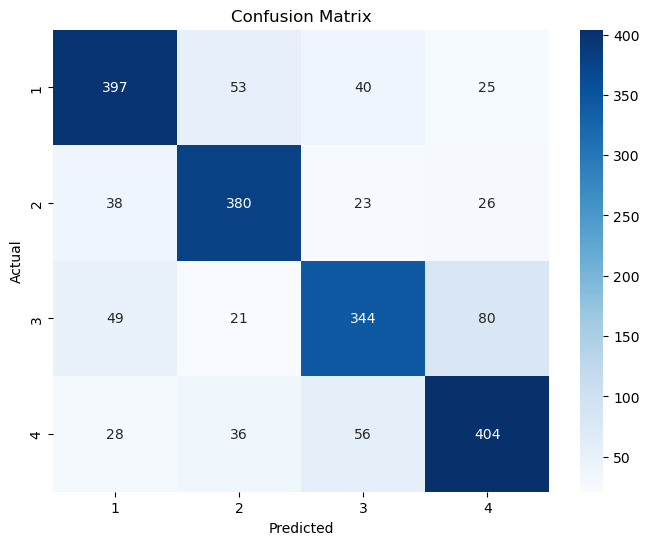

In [67]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
class_names = label_encoder.classes_

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()